## Visualize Track results

In [1]:
from pathlib import Path
import cv2
import sys
import numpy as np
from skimage import feature, measure
import livecell_tracker
from livecell_tracker.core import datasets
from livecell_tracker.core.datasets import LiveCellImageDataset
import livecell_tracker.segment
from livecell_tracker import core
import livecell_tracker.core.utils
from tqdm import tqdm
import json
from livecell_tracker.core import (
    SingleCellTrajectory,
    SingleCellStatic,
    SingleCellTrajectoryCollection,
)

traj_collection_json_path = "../datasets/test_data/traj_analysis/test_trajs.json"
traj_collection_json = json.load(open(traj_collection_json_path, "r"))
trajectory_collection = SingleCellTrajectoryCollection().load_from_json_dict(traj_collection_json)

In [2]:
for t_id in trajectory_collection.track_id_to_trajectory:
    print(trajectory_collection.track_id_to_trajectory[t_id].timeframe_set, end=",")

{0, 1},{0},{0, 1, 2},{0, 1, 2},{0},{0},{0, 1, 2},{0, 1, 2},{0, 1},{0, 1, 2},{0, 1, 2},{0, 1},{0, 1},{0, 1, 2},{0, 1, 2},{0, 1, 2},{0, 1, 2},{0, 1, 2},{0, 1, 2},{0, 1, 2},{0, 1, 2},{0, 1, 2},{0, 1, 2},{0, 1, 2},{0, 1, 2},{0, 1, 2},{0, 1, 2},{0, 1, 2},{0, 1, 2},{2},

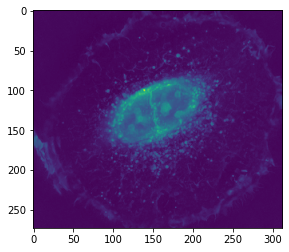

In [5]:
import matplotlib.pyplot as plt
plt.imshow(trajectory_collection.track_id_to_trajectory[1].get_single_cell(0).get_img_crop())